In [390]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from broyden import *
import time

Pi = sym.symbols('pi')
pi = np.pi
n0 = 0.153
hc = 197.326980 # MeV fm

In [391]:
class eos:
    def __init__(self, g_sigma, g_omega, g_rho = 0.0, b = 0.0, c = 0.0):
        
        self.g_sigma = g_sigma
        self.g_omega = g_omega
        self.g_rho = g_rho
        self.b = b
        self.c = c

class baryon:
    def __init__(self, mass, spin, isospin, charge, kind, var_type, mass_eff = 0.0, num_density = 0.0,\
                 frac = 0.0, kf = 0.0, ef = 0.0, chem_pot = 0.0):
    
        # variables to be established at baryon declaration
        self.mass = mass
        self.spin = spin 
        self.isospin = isospin
        self.charge = charge
        self.kind = kind
        self.var_type = var_type
    
        # variables to be stored later
        self.mass_eff = mass_eff
        self.num_density = num_density
        self.frac = frac
        self.kf = kf
        self.ef = ef
        self.chem_pot = chem_pot
        
        # other things
        self.g_sigma = 0.0
        self.g_omega = 0.0 
        self.g_rho = 0.0 
        self.g_phi = 0.0 

class lepton:
    def __init__(self, mass, charge, num_density = 0.0, frac = 0.0, var_type = 0.0, kf = 0.0, chem_pot = 0.0):
        self.mass = mass
        self.charge = charge
        self.num_density = num_density
        self.frac = frac
        self.var_type = var_type
        self.kf = kf
        self.chem_pot = chem_pot

class meson:
    def __init__(self, mass, field = 0.0):
        self.mass = mass # in MeV
        self.field = field
        
class independent_var:
    def __init__(self, var, func, tilde_chem_pot = 0.0, tilde_chem_pot_val = 0.0, num_val = 0.0, total_deriv = 0.0):
        self.var = var # var is the symbol for the variable
        self.func = func 
        
        self.tilde_chem_pot = tilde_chem_pot
        self.tilde_chem_pot_val = tilde_chem_pot_val
        
        self.num_val = num_val
        
        # total derivative of fraction wrt to nB
        self.total_deriv = total_deriv

In [392]:
# glen denning constants
rmf = eos(g_sigma = 8.79509376389, g_omega = 9.1815177, g_rho = 9.7793745, b = 0.00414, c = 0.00716)
rmf_num = eos(g_sigma = 8.79509376389, g_omega = 9.1815177, g_rho = 9.7793745, b = 0.00414, c = 0.00716)

g_sigma, g_omega, g_rho, b, c = sym.symbols('g_sigma, g_omega, g_rho, b, c')

# initializing symbolic eos object
rmf_sym = eos(g_sigma, g_omega, g_rho, b, c)

In [393]:
# electron
electron_sym = lepton(sym.symbols('m_e'), -1, sym.symbols('n_e'), sym.symbols('x_e'), 'Independent',\
                      sym.symbols('k_F_e'), sym.symbols('\mu_e'))
electron_num = lepton(0.510, -1)

# proton 
proton_sym = baryon(sym.symbols('m_p'), 1/2, 1/2, 1, 'Nucleon', 'Dependent', sym.symbols('m_p^*'),\
                    sym.symbols('n_p'), sym.symbols('x_p'), sym.symbols('k_F_p'),\
                    sym.symbols('E^*_F_p'), sym.symbols('mu_p'))
proton_num = baryon(939.0, 1/2, 1/2, 1, 'Nucleon', 'Dependent')

# neutron 
neutron_sym = baryon(sym.symbols('m_n'), 1/2, -1/2, 0, 'Nucleon', 'Dependent', sym.symbols('m_n^*'),\
                    sym.symbols('n_n'), sym.symbols('x_n'), sym.symbols('k_F_n'),\
                    sym.symbols('E^*_F_n'), sym.symbols('mu_n'))
neutron_num = baryon(939.0, 1/2, -1/2, 0, 'Nucleon', 'Dependent')

In [394]:
proton_sym.g_sigma = rmf_sym.g_sigma
proton_num.g_sigma = rmf.g_sigma

proton_sym.g_omega = rmf_sym.g_omega
proton_num.g_omega = rmf.g_omega

proton_sym.g_rho = rmf_sym.g_rho
proton_num.g_rho = rmf.g_rho




neutron_sym.g_sigma = rmf_sym.g_sigma
neutron_num.g_sigma = rmf.g_sigma

neutron_sym.g_omega = rmf_sym.g_omega
neutron_num.g_omega = rmf.g_omega

neutron_sym.g_rho = rmf_sym.g_rho
neutron_num.g_rho = rmf.g_rho

In [395]:
# declaring the symbolic meson objects
sigma_sym = meson(sym.symbols('m_sigma'), sym.symbols('sigma'))
omega_sym = meson(sym.symbols('m_omega'), sym.symbols('omega'))
rho_sym = meson(sym.symbols('m_rho'), sym.symbols('rho'))

# declaring the numeric meson objects
sigma_num = meson(550.0)
omega_num = meson(783.0)
rho_num = meson(770.0)

In [396]:
# initializing independent variables
nb = independent_var(sym.symbols('n_B'), sym.Function('n_B'))
xe = independent_var(sym.symbols('x_e'), sym.Function('x_e'), sym.symbols('mu tilde_x_e'))

In [397]:
baryon_list = [proton_sym, neutron_sym]
baryon_num_list = [proton_num, neutron_num]
meson_list = [sigma_sym, omega_sym, rho_sym]
meson_num_list = [sigma_num, omega_num, rho_num]
lepton_list = [electron_sym]
lepton_num_list = [electron_num]

Practice with solving $\sigma-\omega$ Model
$$
    m_\sigma^2 \sigma + m_N b g_\sigma^3 \sigma^2 + c g_\sigma^4 \sigma^3 = g_\sigma n^s \qquad n^s = \frac{m^*}{\pi^2}\left[k_F E_F - {m^*}^2\ln\frac{k_F + E_F}{m^*}\right]\\
    m_\omega^2 \omega = g_\omega n_B
$$
with constraints
$$
    n_n + n_p = n_B\\
    n_p = n_e
$$

In [398]:
eqn1 = sigma_sym.mass**2*sigma_sym.field + neutron_sym.mass*rmf_sym.b*rmf_sym.g_sigma**3*sigma_sym.field**2 + rmf_sym.c*rmf_sym.g_sigma**4*sigma_sym.field**3 - rmf_sym.g_sigma*(sym.symbols('n_n^s') + sym.symbols('n_p^s'))
eqn1

b*g_sigma**3*m_n*sigma**2 + c*g_sigma**4*sigma**3 - g_sigma*(n_n^s + n_p^s) + m_sigma**2*sigma

In [399]:
ns_n = neutron_sym.mass_eff/Pi**2*(neutron_sym.kf*neutron_sym.ef - neutron_sym.mass_eff**2*sym.log((neutron_sym.kf + neutron_sym.ef)/neutron_sym.mass_eff))
ns_p = proton_sym.mass_eff/Pi**2*(proton_sym.kf*proton_sym.ef - proton_sym.mass_eff**2*sym.log((proton_sym.kf + proton_sym.ef)/proton_sym.mass_eff))

In [400]:
eqn1 = eqn1.subs([(sym.symbols('n_p^s'), ns_p), (sym.symbols('n_n^s'), ns_n)])
eqn1

b*g_sigma**3*m_n*sigma**2 + c*g_sigma**4*sigma**3 - g_sigma*(m_n^**(E^*_F_n*k_F_n - m_n^***2*log((E^*_F_n + k_F_n)/m_n^*))/pi**2 + m_p^**(E^*_F_p*k_F_p - m_p^***2*log((E^*_F_p + k_F_p)/m_p^*))/pi**2) + m_sigma**2*sigma

In [401]:
kf_n = (3*Pi**2*sym.symbols('n_n'))**(1/3)
kf_p = (3*Pi**2*sym.symbols('n_p'))**(1/3)
ef_n = sym.sqrt(kf_n**2 + (neutron_sym.mass - rmf_sym.g_sigma*sigma_sym.field)**2)
ef_p = sym.sqrt(kf_p**2 + (proton_sym.mass - rmf_sym.g_sigma*sigma_sym.field)**2)

In [402]:
eqn1 = eqn1.subs([(neutron_sym.kf, kf_n), (neutron_sym.ef, ef_n), (proton_sym.kf, kf_p), (proton_sym.ef, ef_p)])
eqn1 = eqn1.subs(neutron_sym.mass_eff, neutron_sym.mass - rmf_sym.g_sigma*sigma_sym.field)
eqn1 = eqn1.subs(proton_sym.mass_eff, proton_sym.mass - rmf_sym.g_sigma*sigma_sym.field)
eqn1

b*g_sigma**3*m_n*sigma**2 + c*g_sigma**4*sigma**3 - g_sigma*((-g_sigma*sigma + m_n)*(2.0800838230519*(n_n*pi**2)**0.333333333333333*sqrt((n_n*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m_n)**2) - (-g_sigma*sigma + m_n)**2*log((1.44224957030741*(n_n*pi**2)**0.333333333333333 + 1.44224957030741*sqrt((n_n*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m_n)**2))/(-g_sigma*sigma + m_n)))/pi**2 + (-g_sigma*sigma + m_p)*(2.0800838230519*(n_p*pi**2)**0.333333333333333*sqrt((n_p*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m_p)**2) - (-g_sigma*sigma + m_p)**2*log((1.44224957030741*(n_p*pi**2)**0.333333333333333 + 1.44224957030741*sqrt((n_p*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m_p)**2))/(-g_sigma*sigma + m_p)))/pi**2) + m_sigma**2*sigma

In [403]:
eqn1 = eqn1.subs(sym.symbols('m'), neutron_num.mass)
eqn1 = eqn1.subs([(sym.symbols('b'), rmf.b), (sym.symbols('c'), rmf.c), (rmf_sym.g_sigma, rmf.g_sigma)])
eqn1 = eqn1.subs(sigma_sym.mass, sigma_num.mass)
eqn1 = eqn1.subs(Pi, np.pi)
eqn1 = eqn1.subs([(neutron_sym.num_density, nb.var*(1-electron_sym.frac)),(proton_sym.num_density, nb.var*electron_sym.frac)])
eqn1

2.81657786895125*m_n*sigma**2 + 42.8425110597058*sigma**3 + 302500.0*sigma - 0.891129310402678*(m_n - 8.79509376389*sigma)*(27.2090977269542*(n_B*(1 - x_e))**0.333333333333333*sqrt(0.123727542166605*(n_B*(1 - x_e))**0.666666666666667 + (0.113699754300028*m_n - sigma)**2) - 77.3536743156168*(0.113699754300028*m_n - sigma)**2*log((3.09366772628014*(n_B*(1 - x_e))**0.333333333333333 + 8.79509376389*sqrt(0.123727542166605*(n_B*(1 - x_e))**0.666666666666667 + (0.113699754300028*m_n - sigma)**2))/(m_n - 8.79509376389*sigma))) - 0.891129310402678*(m_p - 8.79509376389*sigma)*(27.2090977269542*(n_B*x_e)**0.333333333333333*sqrt(0.123727542166605*(n_B*x_e)**0.666666666666667 + (0.113699754300028*m_p - sigma)**2) - 77.3536743156168*(0.113699754300028*m_p - sigma)**2*log((3.09366772628014*(n_B*x_e)**0.333333333333333 + 8.79509376389*sqrt(0.123727542166605*(n_B*x_e)**0.666666666666667 + (0.113699754300028*m_p - sigma)**2))/(m_p - 8.79509376389*sigma)))

At this stage, the equation of motion for the sigma field has three unknowns: nB, xe, and sigma. We have a second equation that we can use: beta-equilibrium. Then, we can solve for everything in terms of nB values.

In [404]:
nB = np.arange(0.27, 8.00, 0.01)
nB_mev = nB*n0*hc**3

In [405]:
# Beta Equilibrium

Solving for Particle Fractions
1. We have a few things to consider:
- Baryon number conservation
- Charge neutrality
- Beta equilibrium 
2. When considering just $npe$ matter. We have four unknowns: $n_B, n_p, n_n, n_e$. But we have three equations so we can write everything as a function of $n_B$. 
$$
    n_B = n_p + n_n\\
    n_p = n_e\\
    \mu_n = \mu_p + \mu_e
$$
3. For these equations, it might be more simple to re-write most things in terms of the first two first... 

In [406]:
eqn2 = neutron_sym.chem_pot - proton_sym.chem_pot - electron_sym.chem_pot

In [407]:
eqn2 = eqn2.subs(electron_sym.chem_pot, sym.sqrt(electron_sym.kf**2 + electron_sym.mass**2))
eqn2

mu_n - mu_p - sqrt(k_F_e**2 + m_e**2)

In [408]:
eqn2 = eqn2.subs(proton_sym.chem_pot, sym.sqrt(proton_sym.kf**2 + (proton_sym.mass - rmf_sym.g_sigma*sigma_sym.field)**2))
eqn2

mu_n - sqrt(k_F_e**2 + m_e**2) - sqrt(k_F_p**2 + (-g_sigma*sigma + m_p)**2)

In [409]:
eqn2 = eqn2.subs(neutron_sym.chem_pot, sym.sqrt(neutron_sym.kf**2 + (neutron_sym.mass - rmf_sym.g_sigma*sigma_sym.field)**2))
eqn2

-sqrt(k_F_e**2 + m_e**2) + sqrt(k_F_n**2 + (-g_sigma*sigma + m_n)**2) - sqrt(k_F_p**2 + (-g_sigma*sigma + m_p)**2)

In [410]:
eqn2 = eqn2.subs([(neutron_sym.kf, kf_n), (proton_sym.kf, kf_p), (electron_sym.kf, (3*Pi**2*nb.var*electron_sym.frac)**((1)/3))])
eqn2

-1.44224957030741*sqrt(0.480749856769136*m_e**2 + (n_B*pi**2*x_e)**0.666666666666667) + 1.44224957030741*sqrt((n_n*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m_n)**2) - 1.44224957030741*sqrt((n_p*pi**2)**0.666666666666667 + 0.480749856769136*(-g_sigma*sigma + m_p)**2)

In [411]:
eqn2 = eqn2.subs(sym.symbols('m'), neutron_num.mass)
eqn2 = eqn2.subs(sym.symbols('m_e'), electron_num.mass)
eqn2 = eqn2.subs(sigma_sym.mass, sigma_num.mass)
eqn2 = eqn2.subs(Pi, np.pi)
eqn2 = eqn2.subs(rmf_sym.g_sigma, rmf.g_sigma)
eqn2 = eqn2.subs([(neutron_sym.num_density, nb.var*(1-electron_sym.frac)),(proton_sym.num_density, nb.var*electron_sym.frac)])
eqn2

-8.79509376389*sqrt(0.123727542166605*(n_B*x_e)**0.666666666666667 + (0.113699754300028*m_p - sigma)**2) - 3.09366772628014*sqrt((n_B*x_e)**0.666666666666667 + 0.027176468373837) + 8.79509376389*sqrt(0.123727542166605*(n_B*(1 - x_e))**0.666666666666667 + (0.113699754300028*m_n - sigma)**2)

### Equation 2 down, written in terms of our 3 variables... now we can just iterate through nB and then solve these two system of equations for the two unknowns!

In [412]:
sigma_array = np.zeros(len(nB_mev))
electron_frac = np.zeros(len(nB_mev))

In [413]:
sigma, elec_frac = sym.symbols('sigma x_e')
ind_vars = np.array([sigma, elec_frac])
sys_eqn = np.array([eqn1, eqn2])

x_guess = np.array([8.0, 0.005])

In [414]:
sig_guess = 15.0 
e_frac_guess = 0.005

for i in range(len(nB_mev)):
    eqn_1 = eqn1.subs(nb.var, nB_mev[i])
    eqn_2 = eqn2.subs(nb.var, nB_mev[i])
    
    sys_eqn = np.array([eqn_1, eqn_2])
    
    A = broyden(sys_eqn, ind_vars, np.array([sig_guess, e_frac_guess]))
    
    sigma_array[i] = A[0]
    electron_frac[i] = A[1]
 
    sig_guess = A[0]
    e_frac_guess = A[1]

TypeError: can't convert expression to float

In [417]:
def scalar_density(baryon):
    # returns scalar density n_s
    
    coeff_1 = (2*baryon.spin + 1)/(2*Pi**2)
    coeff_2 = baryon.g_sigma*baryon.mass_eff
    term_2 = baryon.ef*baryon.kf 
    term_2_2 = sym.sqrt(((baryon.ef + baryon.kf)/baryon.mass_eff)**2)
    term_3 = sym.log(term_2_2)
    
    return coeff_1*coeff_2*(term_2 - baryon.mass_eff**2*term_3)

In [415]:
def sigma_eom(baryon_list):
    # returns symbolic sigma equation of motion
    
    m_sigma, sigma, b, c, m_n, g_sigma = sym.symbols('m_sigma sigma b c m_n g_sigma')    
    term_1 = m_sigma**2*sigma + b*m_n*g_sigma**3*sigma**2 + c*g_sigma**4*sigma**3
    
    tot = 0
    
    for baryon in baryon_list:
        tot += g_sigma*scalar_density(baryon)

    return term_1 - tot

In [416]:
def sigma_eom_expanded(baryon_list):
    result = sigma_eom(baryon_list) 
    for baryon in baryon_list:
        result = result.subs(baryon.ef, sym.sqrt(baryon.kf**2 + baryon.mass_eff**2))
        result = result.subs([(baryon.mass_eff, baryon.mass - baryon.g_sigma*sym.symbols('sigma'))])
        result = result.subs(baryon.kf, (3*Pi**2*sym.symbols('n_B')*baryon.frac)**(1/3))
    return result 

In [418]:
def baryon_chem_pot_simplified(baryon):
    # returns symbolic chemical potential for all mesons
    # we can restrict the number of mesons in our system by setting the coupling constants equal to zero! 
    
    sigma, omega, rho, phi = sym.symbols('sigma omega rho phi')
    return sym.sqrt(baryon.kf**2 + baryon.mass_eff**2) + baryon.g_omega*omega + baryon.g_rho*baryon.isospin*rho + baryon.g_phi*phi

In [419]:
def baryon_fermi(baryon):
    nB = sym.symbols('n_B')
    return (3*Pi**2*nB*baryon.frac)**(sym.S(1)/3)

In [420]:
def baryon_chem_pot_expanded(baryon):
    tot = baryon_chem_pot_simplified(baryon)
    return tot.subs([(baryon.mass_eff, baryon.mass - baryon.g_sigma*sigma), (baryon.kf, baryon_fermi(baryon))])

In [421]:
def lepton_chem_pot_expanded(lepton):
    return sym.sqrt(((3*Pi**2*sym.symbols('n_B')*lepton.frac)**(1/3))**2 + lepton.mass**2)

In [422]:
def omega_eom(baryon_list):
    result = 0 
    for baryon in baryon_list:
        result += baryon.g_omega*baryon.num_density
    return sym.symbols('m_omega')**2*sym.symbols('omega') - result

In [423]:
def omega_eom_expanded(baryon_list):
    result = omega_eom(baryon_list) 
    for baryon in baryon_list:
        result = result.subs(baryon.num_density, sym.symbols('n_B')*baryon.frac)
    return result

In [424]:
def rho_eom(baryon_list):
    result = 0
    for baryon in baryon_list:
        result += baryon.g_rho * baryon.num_density * baryon.isospin 
    return sym.symbols('m_rho')**2 * sym.symbols('rho') - result 

In [425]:
def rho_eom_expanded(baryon_list):
    result = rho_eom(baryon_list) 
    for baryon in baryon_list:
        result = result.subs(baryon.num_density, sym.symbols('n_B')*baryon.frac)
    return result 

In [426]:
def phi_eom(baryon_list):
    result = 0 
    for baryon in baryon_list:
        result += baryon.g_phi*baryon.num_density
    return sym.symbols('m_phi')**2*sym.symbols('phi') - result

In [427]:
def phi_eom_expanded(baryon_list):
    result = phi_eom(baryon_list)
    for baryon in baryon_list:
        result = result.subs(baryon.num_density, sym.symbols('n_B')*baryon.frac)
    return result 

In [428]:
def beta_equilibrium(baryon):
    return baryon.chem_pot - neutron_sym.chem_pot + baryon.charge * electron_sym.chem_pot

In [429]:
beta_equilibrium(proton_sym)

\mu_e - mu_n + mu_p

In [430]:
def beta_equilibrium_expanded(baryon):
    result = beta_equilibrium(baryon)
    result = result.subs([(baryon.chem_pot, baryon_chem_pot_expanded(baryon)),\
                          (neutron_sym.chem_pot, baryon_chem_pot_expanded(neutron_sym)),\
                          (electron_sym.chem_pot, lepton_chem_pot_expanded(electron_sym) )])
    return result 

In [431]:
beta_equilibrium_expanded(proton_sym)

1.0*g_rho*rho + 1.44224957030741*sqrt(0.480749856769136*m_e**2 + (n_B*pi**2*x_e)**0.666666666666667) - sqrt(3**(2/3)*(n_B*pi**2*x_n)**(2/3) + (-g_sigma*sigma + m_n)**2) + sqrt(3**(2/3)*(n_B*pi**2*x_p)**(2/3) + (-g_sigma*sigma + m_p)**2)

In [432]:
rho_eom(baryon_list)

0.5*g_rho*n_n - 0.5*g_rho*n_p + m_rho**2*rho

In [433]:
omega_eom(baryon_list)

-g_omega*n_n - g_omega*n_p + m_omega**2*omega

In [434]:
sigma_eom(baryon_list)

b*g_sigma**3*m_n*sigma**2 + c*g_sigma**4*sigma**3 - 1.0*g_sigma**2*m_n^**(E^*_F_n*k_F_n - m_n^***2*log(sqrt((E^*_F_n + k_F_n)**2/m_n^***2)))/pi**2 - 1.0*g_sigma**2*m_p^**(E^*_F_p*k_F_p - m_p^***2*log(sqrt((E^*_F_p + k_F_p)**2/m_p^***2)))/pi**2 + m_sigma**2*sigma

In [435]:
eqn1 = sigma_eom_expanded(baryon_list)
eqn2 = omega_eom_expanded(baryon_list)
eqn3 = rho_eom_expanded(baryon_list)
eqn4 = beta_equilibrium_expanded(proton_sym)

In [436]:
def substitution(equation, baryon_sym_list, baryon_num_list, meson_sym_list, meson_num_list, lepton_sym_list, lepton_num_list, rmf_num):
    for i in range(len(baryon_list)):
        equation = equation.subs([(baryon_sym_list[i].mass, baryon_num_list[i].mass), (baryon_sym_list[i].kf, baryon_num_list[i].kf),\
                                 (sym.symbols('b'), rmf_num.b), (sym.symbols('c'), rmf_num.c),\
                                 (baryon_sym_list[i].g_sigma, baryon_num_list[i].g_sigma),\
                                 (baryon_sym_list[i].g_omega, baryon_num_list[i].g_omega),\
                                 (baryon_sym_list[i].g_rho, baryon_num_list[i].g_rho)])
    
    for i in range(len(meson_sym_list)):
        equation = equation.subs(meson_sym_list[i].mass, meson_num_list[i].mass)
    
    for i in range(len(lepton_sym_list)):
        equation = equation.subs(lepton_sym_list[i].mass, lepton_num_list[i].mass)
        
    equation = equation.subs(Pi, np.pi)
    return equation 

In [437]:
def substitution_2(equation, baryon_sym_list, baryon_num_list, meson_sym_list, meson_num_list, lepton_sym_list, lepton_num_list, rmf_num):
    for i in range(len(baryon_list)):
        equation = equation.subs([(baryon_sym_list[i].mass, baryon_num_list[i].mass),\
                                 (sym.symbols('b'), rmf_num.b), (sym.symbols('c'), rmf_num.c),\
                                 (baryon_sym_list[i].g_sigma, baryon_num_list[i].g_sigma),\
                                 (baryon_sym_list[i].g_omega, baryon_num_list[i].g_omega),\
                                 (baryon_sym_list[i].g_rho, baryon_num_list[i].g_rho)])
    
    for i in range(len(meson_sym_list)):
        equation = equation.subs(meson_sym_list[i].mass, meson_num_list[i].mass)
    
    for i in range(len(lepton_sym_list)):
        equation = equation.subs(lepton_sym_list[i].mass, lepton_num_list[i].mass)
        
    equation = equation.subs(Pi, np.pi)
    return equation 

In [438]:
listt = [baryon_list, baryon_num_list, meson_list, meson_num_list, lepton_list, lepton_num_list, rmf_num]

eqn_1 = substitution(eqn1, *listt)
eqn_2 = substitution(eqn2, *listt)
eqn_3 = substitution(eqn3, *listt)
eqn_4 = substitution(eqn4, *listt)

### Unknowns
- We see that we have $n_B, x_n, x_p, x_e, \sigma, \rho, \omega$ as unknowns (7 unknowns). We have two more conditions: baryon number conservation and charge neutrality. This brings us to 6 equations and 7 unknowns. Hence, taking $n_B$ to be fixed, we can solve for all the other variables.

In [439]:
def baryon_num_conservation(baryon_list):
    result = 0
    for baryon in baryon_list:
        result += baryon.frac
    return 1 - result

In [440]:
def charge_neutrality(baryon_list, lepton_list):
    result = 0
    for baryon in baryon_list:
        if (baryon.charge > 0):
            result += baryon.frac
        elif (baryon.charge < 0):
            result -= baryon.frac
    
    for lepton in lepton_list:
        if (lepton.charge > 0):
            result += lepton.frac
        elif (lepton.charge < 0):
            result -= lepton.frac 
            
    return result 

In [441]:
eqn_5 = charge_neutrality(baryon_list, lepton_list)

In [442]:
eqn_6 = baryon_num_conservation(baryon_list)

In [443]:
xn, xp,xe, sig, rho, omega = sym.symbols('x_n x_p x_e sigma rho omega')
sys_eqn = [eqn_1, eqn_2, eqn_3, eqn_4, eqn_5, eqn_6]
ind_var = [xn, xp, xe, sig, rho, omega]
x_guess = [0.99, 0.01, 0.01, 20.0, 1.0, 4.5]

In [444]:
nb_array = np.arange(0.27, 0.5, 0.01)
nB_array_mev = nb_array*n0*hc**3

xn_array = np.copy(nb_array)
xp_array = np.copy(nb_array)
xe_array = np.copy(nb_array)
sig_array = np.copy(nb_array)
rho_array = np.copy(nb_array)
omega_array = np.copy(nb_array)

In [445]:
for i in range(len(nB_mev)):
    eqn__1 = eqn_1.subs(nb.var, nB_array_mev[i])
    eqn__2 = eqn_2.subs(nb.var, nB_array_mev[i])
    eqn__3 = eqn_2.subs(nb.var, nB_array_mev[i])
    eqn__4 = eqn_2.subs(nb.var, nB_array_mev[i])
    eqn__5 = eqn_2.subs(nb.var, nB_array_mev[i])
    eqn__6 = eqn_2.subs(nb.var, nB_array_mev[i])
    
    sys_eqn = np.array([eqn_1, eqn_2, eqn__3, eqn__4, eqn__5, eqn__6])
    
    A = broyden(sys_eqn, ind_var, x_guess)
    
    xn_array[i] = A[0]
    xp_array[i] = A[1]
    xe_array[i] = A[2]
    sig_array[i] = A[3]
    rho_array[i] = A[4]
    omega_array[i] = A[5]
    
    x_guess = A

TypeError: can't convert expression to float

# $\sigma-\omega$ Model for NPE
$$
    m_\sigma^2 \sigma + \frac{dU}{d\sigma} = g_\sigma (n_n^s +n_p^s) \qquad n_N^s = \frac{m_*}{\pi^2}\left[k_N \sqrt{k_N^2 + m_*^2} - m_*^2\ln\frac{k_N + \sqrt{k_N^2 + m_*^2}}{m_*}\right]\\
    m_\omega^2 \omega = g_\omega n_B\\
    n_B = \frac{k_n^3}{3\pi^2} + \frac{k_p^3}{3\pi^2}\\
    k_p = k_e\\
    \mu_p + \mu_e = \mu_n
$$
This latter condition is given by
$$
    \sqrt{k_p^2 + (m_N - g_\sigma \sigma)^2} + \sqrt{k_e^2 + m_e^2} = \sqrt{k_n^2 + (m_N - g_\sigma \sigma)^2}
$$
Unknowns are: $n_B, \sigma, \omega, k_n, k_p, k_e$. Have 5 equations, 6 unknowns. Take $n_B$ and fix it and find all other values.

In [446]:
def sigma_eom_expanded_2(baryon_list):
    result = sigma_eom(baryon_list) 
    for baryon in baryon_list:
        result = result.subs(baryon.ef, sym.sqrt(baryon.kf**2 + baryon.mass_eff**2))
        result = result.subs([(baryon.mass_eff, baryon.mass - baryon.g_sigma*sym.symbols('sigma'))])
    return result 

In [447]:
sigma_eom_expanded_2(baryon_list)

b*g_sigma**3*m_n*sigma**2 + c*g_sigma**4*sigma**3 - 1.0*g_sigma**2*(-g_sigma*sigma + m_n)*(k_F_n*sqrt(k_F_n**2 + (-g_sigma*sigma + m_n)**2) - (-g_sigma*sigma + m_n)**2*log(sqrt((k_F_n + sqrt(k_F_n**2 + (-g_sigma*sigma + m_n)**2))**2/(-g_sigma*sigma + m_n)**2)))/pi**2 - 1.0*g_sigma**2*(-g_sigma*sigma + m_p)*(k_F_p*sqrt(k_F_p**2 + (-g_sigma*sigma + m_p)**2) - (-g_sigma*sigma + m_p)**2*log(sqrt((k_F_p + sqrt(k_F_p**2 + (-g_sigma*sigma + m_p)**2))**2/(-g_sigma*sigma + m_p)**2)))/pi**2 + m_sigma**2*sigma

In [448]:
def omega_eom_expanded_2():
    return sym.symbols('m_omega')**2*sym.symbols('omega') - sym.symbols('g_omega')*sym.symbols('n_B')

In [449]:
def charge_conservation_2():
    return proton_sym.kf - electron_sym.kf

In [450]:
def baryon_conservation_2():
    return 3*Pi**2*sym.symbols('n_B') - proton_sym.kf**3 - neutron_sym.kf**3

In [451]:
def beta_equilibrium():
    return - sym.sqrt(proton_sym.kf**2 + (proton_sym.mass - proton_sym.g_sigma*sym.symbols('sigma'))**2) - \
        sym.sqrt(electron_sym.kf**2 + electron_sym.mass**2)\
        + sym.sqrt(neutron_sym.kf**2 + (neutron_sym.mass - neutron_sym.g_sigma*sym.symbols('sigma'))**2)
beta_equilibrium()

-sqrt(k_F_e**2 + m_e**2) + sqrt(k_F_n**2 + (-g_sigma*sigma + m_n)**2) - sqrt(k_F_p**2 + (-g_sigma*sigma + m_p)**2)

In [469]:
sigma_eqn_motion = sigma_eom_expanded_2(baryon_list)
sigma_eqn_motion

b*g_sigma**3*m_n*sigma**2 + c*g_sigma**4*sigma**3 - 1.0*g_sigma**2*(-g_sigma*sigma + m_n)*(k_F_n*sqrt(k_F_n**2 + (-g_sigma*sigma + m_n)**2) - (-g_sigma*sigma + m_n)**2*log(sqrt((k_F_n + sqrt(k_F_n**2 + (-g_sigma*sigma + m_n)**2))**2/(-g_sigma*sigma + m_n)**2)))/pi**2 - 1.0*g_sigma**2*(-g_sigma*sigma + m_p)*(k_F_p*sqrt(k_F_p**2 + (-g_sigma*sigma + m_p)**2) - (-g_sigma*sigma + m_p)**2*log(sqrt((k_F_p + sqrt(k_F_p**2 + (-g_sigma*sigma + m_p)**2))**2/(-g_sigma*sigma + m_p)**2)))/pi**2 + m_sigma**2*sigma

In [463]:
sigma_eqn_motion = sigma_eom_expanded_2(baryon_list)
sigma_eqn_motion_1 = substitution_2(sigma_eqn_motion, *listt) 

omega_eqn_motion = omega_eom_expanded_2()
omega_eqn_motion_1 = substitution_2(omega_eqn_motion, *listt)

beta_equilibrium_eqn = beta_equilibrium()
beta_equilibrium_eqn_1 = substitution_2(beta_equilibrium_eqn, *listt)

charge_conservation_eqn = charge_conservation_2()
charge_conservation_eqn_1 = substitution_2(charge_conservation_eqn, *listt)

baryon_conservation_eqn = baryon_conservation_2()
baryon_conservation_eqn_1 = substitution_2(baryon_conservation_eqn, *listt)

In [464]:
sys_eqn = [sigma_eqn_motion_1, omega_eqn_motion_1, beta_equilibrium_eqn_1,\
           charge_conservation_eqn_1, baryon_conservation_eqn_1]

In [465]:
sys_eqn[0]

42.8425110597058*sigma**3 + 2644.76661894523*sigma**2 + 302500.0*sigma - 7.83756584074219*(939.0 - 8.79509376389*sigma)*(939.0*k_F_n*sqrt(1.13414560841808e-6*k_F_n**2 + (1 - 0.0093664470328967*sigma)**2) - 881721.0*(1 - 0.0093664470328967*sigma)**2*log(1.0*sqrt((0.00106496272630458*k_F_n + sqrt(1.13414560841808e-6*k_F_n**2 + (1 - 0.0093664470328967*sigma)**2))**2/(1 - 0.0093664470328967*sigma)**2))) - 7.83756584074219*(939.0 - 8.79509376389*sigma)*(939.0*k_F_p*sqrt(1.13414560841808e-6*k_F_p**2 + (1 - 0.0093664470328967*sigma)**2) - 881721.0*(1 - 0.0093664470328967*sigma)**2*log(1.0*sqrt((0.00106496272630458*k_F_p + sqrt(1.13414560841808e-6*k_F_p**2 + (1 - 0.0093664470328967*sigma)**2))**2/(1 - 0.0093664470328967*sigma)**2)))

In [454]:
x_guess = [20.00, 4.50, -43.0, -43.0, 210.0]

In [466]:
sigma, omega, kp, ke, kn = sym.symbols('sigma omega k_F_p k_F_e k_F_n')
ind_vars = np.array([sigma, omega, kp, ke, kn])
nb_orig = 0.27
nb_val = nb_orig*0.153*hc**3

In [467]:
for i in range(len(sys_eqn)):
    sys_eqn[i] = sys_eqn[i].subs(sym.symbols('n_B'), nb_val)

In [457]:
A = Newton(sys_eqn, ind_vars, x_guess)

In [470]:
A.solution

array([ 66.6127564362545  ,   4.753413052852253, -54.66706503913398 ,
       -54.66706503913398 , 212.24629747281725 ])

In [475]:
sys_eqn[4]

-k_F_n**3 - k_F_p**3 + 9398003.50924671

### Updates
- Original problem: solver had issues where complex numbers appeared and would fail due to not being able to represent complex numbers. We shouldn't have complex number to begin with... 
- Seemed to have found the issue. When the nonlinear solver tries to update through the natural log, sometimes it will pass a value that makes the argument negative so that the result is complex. The fix is to make it so that the log's argument is always positive. So we take
$$
    \log(x) \rightarrow \log(\sqrt{x^2})
$$
which should be okay?
- Another issue is sometimes it will yield values that are negative for values that shouldn't be? Like the fermi momenta will sometimes be negative. Which is due solving square roots and stuff. Not sure how to approach this. Not sure if we can include conditionals in this or inequalities?

## Solving $\sigma-\omega$ model for limited range of values
- Appears successful

In [459]:
nb_array = np.arange(0.27, 0.5, 0.01)
nB_array_mev = nb_array*n0*hc**3

kf_neutron_array = np.copy(nb_array)
kf_proton_array = np.copy(nb_array)
kf_electron_array = np.copy(nb_array)
sig_array = np.copy(nb_array)
omega_array = np.copy(nb_array)


In [462]:
sys_eqn

[42.8425110597058*sigma**3 + 2644.76661894523*sigma**2 + 302500.0*sigma - 7.83756584074219*(939.0 - 8.79509376389*sigma)*(939.0*k_F_n*sqrt(1.13414560841808e-6*k_F_n**2 + (1 - 0.0093664470328967*sigma)**2) - 881721.0*(1 - 0.0093664470328967*sigma)**2*log(1.0*sqrt((0.00106496272630458*k_F_n + sqrt(1.13414560841808e-6*k_F_n**2 + (1 - 0.0093664470328967*sigma)**2))**2/(1 - 0.0093664470328967*sigma)**2))) - 7.83756584074219*(939.0 - 8.79509376389*sigma)*(939.0*k_F_p*sqrt(1.13414560841808e-6*k_F_p**2 + (1 - 0.0093664470328967*sigma)**2) - 881721.0*(1 - 0.0093664470328967*sigma)**2*log(1.0*sqrt((0.00106496272630458*k_F_p + sqrt(1.13414560841808e-6*k_F_p**2 + (1 - 0.0093664470328967*sigma)**2))**2/(1 - 0.0093664470328967*sigma)**2))),
 -9.1815177*n_B + 613089.0*omega,
 -sqrt(k_F_e**2 + 0.2601) + 939.0*sqrt(1.13414560841808e-6*k_F_n**2 + (1 - 0.0093664470328967*sigma)**2) - 939.0*sqrt(1.13414560841808e-6*k_F_p**2 + (1 - 0.0093664470328967*sigma)**2),
 -k_F_e + k_F_p,
 -k_F_n**3 - k_F_p**3 + 29.

In [460]:
sys_eqn = [sigma_eqn_motion_1, omega_eqn_motion_1, beta_equilibrium_eqn_1,\
           charge_conservation_eqn_1, baryon_conservation_eqn_1]
sys_eqn_2 = ['NaN', 'NaN', 'NaN', 'NaN', 'NaN']
x_guess = [8.00, 4.50, 43.0, 43.0, 210.0]

In [461]:
for i in range(len(nB_array_mev)):
    for j in range(len(sys_eqn)):
        sys_eqn_2[j] = sys_eqn[j].subs(sym.symbols('n_B'), nB_array_mev[i])
    
   
    answer = Newton(sys_eqn_2, ind_vars, x_guess)
    
    sig_array[i] = answer.solution[0]
    omega_array[i] = answer.solution[1]
    kf_proton_array[i] = answer.solution[2]
    kf_electron_array[i] = answer.solution[3]
    kf_neutron_array[i] = answer.solution[4]
    
    x_guess = answer.solution

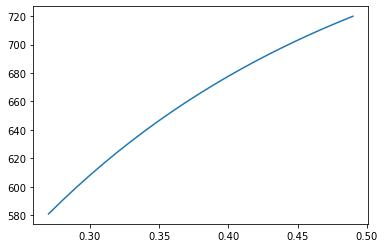

In [388]:
plt.plot(nb_array, 8.7*sig_array)
#plt.plot(nb_array, omega_array)
plt.show()

### Fraction Calculator, among other things...

In [368]:
def fraction(fermi, nB):
    # takes fermi energy and baryon density and finds corresponding fraction 
    return fermi**3/3/pi**2/nB

In [369]:
electron_frac = np.copy(nb_array)
proton_frac = np.copy(nb_array)
neutron_frac = np.copy(nb_array)

In [370]:
for i in range(len(nB_array_mev)):
    electron_frac[i] = fraction(kf_electron_array[i], nB_array_mev[i])
    proton_frac[i] = fraction(kf_proton_array[i], nB_array_mev[i])
    neutron_frac[i] = fraction(kf_neutron_array[i], nB_array_mev[i])